# Harmonization across studies with *NHLBI BioData Catalyst® (BDC) Powered by PIC-SURE*

This tutorial notebook will demonstrate how to query and work with the BDC studies, particularly cross-study harmonization. For a more step-by-step introduction to the python PIC-SURE API, see the `1_PICSURE_API_101.ipynb` notebook.

**Before running this notebook, please be sure to review the \"Get your security token\" documentation, which exists in the [`README.md` file](../README.md). It explains about how to get a security token, which is mandatory to access the databases.**

 -------   

# Environment set-up

### System requirements
- Python 3.6 or later
- pip python package manager, already available in most systems with a python interpreter installed


### Install packages

**Note that if you are using the dedicated PIC-SURE environment within the *BDC Powered by Seven Bridges* platform, the necessary packages have already been installed.**

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# BDC Powered by Terra users uncomment the following line to specify package install location
# sys.path.insert(0, r"/home/jupyter/.local/lib/python3.7/site-packages")
!pip install matplotlib-venn
from matplotlib_venn import venn2


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for matplotlib-venn: filename=matplotlib_venn-0.11.9-py3-none-any.whl size=33000 sha256=6fff19713c720b0e983a70aee575177907ce9a819ccdd7485c88dcd95dc65fa5
  Stored in directory: /home/jovyan/.cache/pip/wheels/25/de/d4/29dfc5d4520b956df7bc54a8464ad053042918bc525e88bf66
Successfully built matplotlib-venn


In [2]:
!{sys.executable} -m pip install --upgrade --force-reinstall git+https://github.com/hms-dbmi/pic-sure-python-client.git
!{sys.executable} -m pip install --upgrade --force-reinstall git+https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git
!{sys.executable} -m pip install --upgrade --force-reinstall git+https://github.com/hms-dbmi/pic-sure-biodatacatalyst-python-adapter-hpds.git

  Cloning https://github.com/hms-dbmi/pic-sure-python-client.git to /tmp/pip-req-build-q878d7fu
  Running command git clone -q https://github.com/hms-dbmi/pic-sure-python-client.git /tmp/pip-req-build-q878d7fu
  Resolved https://github.com/hms-dbmi/pic-sure-python-client.git to commit aabcc6574eede2dc3de410c6c75f7f77ea18d23c
  Created wheel for PicSureClient: filename=PicSureClient-0.1.0-py2.py3-none-any.whl size=10324 sha256=f2aa40854b79ce6e994c2d5b022ec0c2b32f0a014d13fd18ad9a2a9287c0305d
  Stored in directory: /tmp/pip-ephem-wheel-cache-aakmv7zz/wheels/88/a3/ee/ea12f2255cde18e11aa3a9091131fe8e56e5224630c914619b
Successfully built PicSureClient
  Cloning https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git to /tmp/pip-req-build-k2m6lx86
  Running command git clone -q https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git /tmp/pip-req-build-k2m6lx86
  Resolved https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git to commit ef653f4d5b2ba7156821a134bbc4bfca74f5ebbc
 

In [3]:
import PicSureClient
import PicSureBdcAdapter

## Connecting to a PIC-SURE network

In [5]:
PICSURE_network_URL = "https://picsure.biodatacatalyst.nhlbi.nih.gov/picsure"
token_file = "token.txt"

with open(token_file, "r") as f:
    my_token = f.read()
    
bdc = PicSureBdcAdapter.Adapter(PICSURE_network_URL, my_token)

+--------------------------------------+------------------------------------------------------+
|  Resource UUID                       |  Resource Name                                       |
+--------------------------------------+------------------------------------------------------+
| 70c837be-5ffc-11eb-ae93-0242ac130002 | open-hpds                                            |
| ca0ad4a9-130a-3a8a-ae00-e35b07f1108b | visualization                                        |
| 02e23f52-f354-4e8b-992c-d37c8b9ba140 | auth-hpds                                            |
| 36363664-6231-6134-2d38-6538652d3131 | dictionary                                           |
+--------------------------------------+------------------------------------------------------+


 -------   

## Harmonizing variables with PIC-SURE
One of the key challenges to conducting analyses with several studies is ensuring correct data harmonization, or combining of data from different sources. There are many harmonization techniques, but this notebook will demonstrate an approach to finding and extracting similar variables from different studies in PIC-SURE. Two examples of this will be shown:
1. Retrieving variables for *sex and gender* across studies with BMI
2. Harmonizing the *"orthopnea"* and *"pneumonia"* variables across studies


*For more information about the TOPMed DCC Harmonized Data Set in PIC-SURE, please refer to the `2_TOPMed_DCC_Harmonized_Variables_analysis.ipynb` notebook*

-----

## Sex and gender variables across studies
<font color='darkgreen'>**Goal: Create harmonized variables for sex and BMI which combine data from multiple studies**</font> 

These variables are labelled differently for each of these studies. For example, some use the keyword `sex` while others use `gender`. To acccount for these differences, we need to develop a way to search for multiple keywords at once.

Let's start by searching for `sex` and `gender` to gain a better understanding of the variables that exist in PIC-SURE with these terms. The dictionary().find method can take in regular expressions. Here, we take advantage of this by searching for both sex and gender in the same regular expression.


In [6]:
sex_dictionary = bdc.useDictionary().dictionary().find('sex|gender')
sex_dataframe = sex_dictionary.dataframe()
print(sex_dataframe.shape)
sex_dataframe.head()

(2304, 33)


,values,studyId,dtId,varId,is_categorical,is_continuous,columnmeta_is_stigmatized,columnmeta_name,description,columnmeta_min,...,columnmeta_study_id,is_stigmatized,derived_var_name,derived_study_abv_name,derived_study_description,columnmeta_var_group_id,derived_group_name,columnmeta_HPDS_PATH,min,max
0,"[Female, Male]",phs002694,All Variables,GENDER,True,False,false,GENDER,Biological sex,,...,phs002694,false,GENDER,ACTIV4a,"COVID-19 ACTIV-4 ACUTE: A Multicenter, Adaptiv...",All Variables,,\phs002694\GENDER\,NaN,NaN
1,"[Female, Male]",phs002710,All Variables,GENDER,True,False,false,GENDER,Biological sex,,...,phs002710,false,GENDER,ACTIV4b,COVID-19 Outpatient Thrombosis Prevention Tria...,All Variables,,\phs002710\GENDER\,NaN,NaN
2,"[Female, Male]",phs000007,pht000183,phv00024071,True,False,false,sex,Gender,,...,phs000007,false,sex,FHS,SHARe pedigrees: all participants. The variabl...,pht000183,Framingham_Pedigree,\phs000007\pht000183\phv00024071\sex\,NaN,NaN
3,"[Female, Male]",phs000422,pht003225,phv00181856,True,False,false,ESP_SEX,Gender of participant,,...,phs000422,false,ESP_SEX,SARP,GO Sub-study (LUNGGO),pht003225,LungGO_SevereAsthma_Subject_Phenotypes,\phs000422\pht003225\phv00181856\ESP_SEX\,NaN,NaN
4,"[Female, Male]",phs000820,pht004332,phv00219057,True,False,false,sex,Gender of participant,,...,phs000820,false,sex,CCAF,The dataset provides information about the aff...,pht004332,Lone_Atrial_Fibrillation_Subject_Phenotypes,\phs000820\pht004332\phv00219057\sex\,NaN,NaN


After reviewing the variables using the dataframe (or the [user interface](https://picsure.biodatacatalyst.nhlbi.nih.gov/psamaui/login)), let's say we are interested in sex/gender variables from the following studies:
- ECLIPSE (Evaluation of COPD Longitudinally to Identify Predictive Surrogate Endpoints) (phs001252)
- EOCOPD (Early Onset of COPD) (phs000946)

We can find the study IDs in the Data Access Dashboard in the user interface.

We have already used the PIC-SURE API dictionary object and find method to find variables which contain the keywords sex and gender. Let's filter these results to our desired studies of interest.

### Which sex variable in ECLIPSE should we use? 

First, we will filter our sex/gender variables to only look at those from the ECLIPSE study.

We can see that there are many sex/gender variables in ECLIPSE originating from various data tables.

We will examine the data associated with these variables to determine which one to use for our analysis.

In [7]:
# which sex/gender variables are part of ECLIPSE?
eclipse_vars = sex_dataframe['columnmeta_study_id'].str.contains('phs001252')

# create a subset of only ECLIPSE sex/gender vars
eclipse_sex_df = sex_dataframe[eclipse_vars][['columnmeta_study_id', 'columnmeta_var_group_description', 'columnmeta_name', 'columnmeta_description', 'values', 'columnmeta_HPDS_PATH']]
eclipse_sex_df

,columnmeta_study_id,columnmeta_var_group_description,columnmeta_name,columnmeta_description,values,columnmeta_HPDS_PATH
21,phs001252,,GENDER,Sex,"[Female, Male]",\phs001252\pht006373\phv00293588\GENDER\
471,phs001252,,BICAT,Biomarker,"[Adiponectin, Beta-Defensin-2, Brain-derived n...",\phs001252\pht006371\phv00293430\BICAT\
1768,phs001252,,SEX,Sex,"[Female, Male]",\phs001252\pht006368\phv00293203\SEX\
1769,phs001252,,SEX,Sex,"[Female, Male]",\phs001252\pht006369\phv00293369\SEX\
1770,phs001252,,SEX,Sex,"[Female, Male]",\phs001252\pht006371\phv00293425\SEX\
1771,phs001252,,SEX,Sex,"[Female, Male]",\phs001252\pht006373\phv00293583\SEX\
1772,phs001252,,SEX,Sex,"[Female, Male]",\phs001252\pht006376\phv00293645\SEX\
1773,phs001252,,SEX,Sex,"[Female, Male]",\phs001252\pht006377\phv00293673\SEX\
1774,phs001252,,SEX,Sex,"[Female, Male]",\phs001252\pht006378\phv00293684\SEX\
1775,phs001252,,SEX,Sex,"[Female, Male]",\phs001252\pht006380\phv00293813\SEX\


We can see that the results there is a variable called `BICAT` or "Biomarker". This variable was selected because one of the values associated with this variable is "Sex hormone binding globulin" and was returned with our search. However, this is not a sex/gender variable and we should remove this.

In [12]:
eclipse_sex_df = eclipse_sex_df[eclipse_sex_df['columnmeta_name'] != "BICAT"]

Many studies may have multiple variables with similar names and descriptions that come from different data tables. This will vary from study to study based on how the original study was conducted and organized. 

We will approach this complication by examining the data associated with each sex / gender variables in ECLIPSE and determining which would be the best fit for our analysis.

Because we want to examine the patient level data, we will create a query using all sex/gender variables in ECLIPSE. We will add these variables to our query using the `anyof` method, as we are interested in all observations with a value for any of our chosen variables.

In [13]:
# Initialize a query
authPicSure = bdc.useAuthPicSure()
eclipse_sex_query = authPicSure.query()
eclipse_sex_query.anyof().add(eclipse_sex_df['columnmeta_HPDS_PATH'])
eclipse_sex_results = eclipse_sex_query.getResultsDataFrame()
eclipse_sex_results.head()

,Patient ID,\_Parent Study Accession with Subject ID\,\_Topmed Study Accession with Subject ID\,\_consents\,\phs001252\pht006368\phv00293203\SEX\,\phs001252\pht006369\phv00293369\SEX\,\phs001252\pht006371\phv00293425\SEX\,\phs001252\pht006373\phv00293583\SEX\,\phs001252\pht006373\phv00293588\GENDER\,\phs001252\pht006376\phv00293645\SEX\,...,\phs001252\pht006393\phv00294037\SEX\,\phs001252\pht006394\phv00294111\SEX\,\phs001252\pht006396\phv00294170\SEX\,\phs001252\pht006397\phv00294201\SEX\,\phs001252\pht006399\phv00294239\SEX\,\phs001252\pht006400\phv00294249\SEX\,\phs001252\pht006401\phv00294264\SEX\,\phs001252\pht006402\phv00294277\SEX\,\phs001252\pht006403\phv00294311\SEX\,\phs001252\pht006404\phv00294337\SEX\
0,34717,phs001252.v1_ecl122536,NaN,phs001252.c1,Female,Female,Female,Female,Female,NaN,...,Female,NaN,Female,NaN,NaN,Female,Female,Female,Female,Female
1,34718,phs001252.v1_ecl122472,NaN,phs001252.c1,Female,Female,Female,Female,Female,NaN,...,Female,NaN,Female,NaN,NaN,Female,Female,Female,Female,Female
2,34719,phs001252.v1_ecl122464,NaN,phs001252.c1,Male,Male,Male,Male,Male,Male,...,Male,NaN,Male,Male,NaN,Male,Male,Male,Male,Male
3,34720,phs001252.v1_ecl122401,NaN,phs001252.c1,Female,Female,Female,Female,Female,NaN,...,Female,NaN,Female,Female,NaN,Female,Female,Female,Female,Female
4,34721,phs001252.v1_ecl122383,NaN,phs001252.c1,Male,Male,Male,Male,Male,NaN,...,Male,NaN,Male,Male,NaN,Male,Male,Male,Male,Male


We used the `.getResultsDataFrame()` method to organize our participant level results in a dataframe that is easy to work with using pandas. By previewing the resulting dataframe, we can see that not all of the sex and gender variables are complete for our participant subset. 

Let's see which sex/gender variables are the most complete for our dataset by counting the number of NA values in each one. 

In [14]:
# first let's see which sex/gender variables are the most complete for our dataset by counting the number of NA values
print(eclipse_sex_results.isna().sum())

Patient ID                                      0
\_Parent Study Accession with Subject ID\       0
\_Topmed Study Accession with Subject ID\    2746
\_consents\                                     0
\phs001252\pht006368\phv00293203\SEX\           5
\phs001252\pht006369\phv00293369\SEX\          13
\phs001252\pht006371\phv00293425\SEX\           8
\phs001252\pht006373\phv00293583\SEX\          13
\phs001252\pht006373\phv00293588\GENDER\       13
\phs001252\pht006376\phv00293645\SEX\        1800
\phs001252\pht006377\phv00293673\SEX\         608
\phs001252\pht006378\phv00293684\SEX\           8
\phs001252\pht006380\phv00293813\SEX\           0
\phs001252\pht006381\phv00293824\SEX\           0
\phs001252\pht006382\phv00293832\SEX\           0
\phs001252\pht006383\phv00293848\SEX\           6
\phs001252\pht006384\phv00293879\SEX\         464
\phs001252\pht006386\phv00293898\SEX\           0
\phs001252\pht006387\phv00293919\SEX\           8
\phs001252\pht006388\phv00293935\SEX\           8


We can see that there are a few variables with 0 NA values, we would like to focus on these.

In [15]:
# let's focus on those variables which do not have any NA values
filtered_eclipse_sex_results = eclipse_sex_results.loc[:, eclipse_sex_results.isna().sum() == 0]
filtered_eclipse_sex_results

,Patient ID,\_Parent Study Accession with Subject ID\,\_consents\,\phs001252\pht006380\phv00293813\SEX\,\phs001252\pht006381\phv00293824\SEX\,\phs001252\pht006382\phv00293832\SEX\,\phs001252\pht006386\phv00293898\SEX\,\phs001252\pht006391\phv00293967\SEX\,\phs001252\pht006393\phv00294037\SEX\,\phs001252\pht006400\phv00294249\SEX\
0,34717,phs001252.v1_ecl122536,phs001252.c1,Female,Female,Female,Female,Female,Female,Female
1,34718,phs001252.v1_ecl122472,phs001252.c1,Female,Female,Female,Female,Female,Female,Female
2,34719,phs001252.v1_ecl122464,phs001252.c1,Male,Male,Male,Male,Male,Male,Male
3,34720,phs001252.v1_ecl122401,phs001252.c1,Female,Female,Female,Female,Female,Female,Female
4,34721,phs001252.v1_ecl122383,phs001252.c1,Male,Male,Male,Male,Male,Male,Male
...,...,...,...,...,...,...,...,...,...,...
2741,52941,phs001252.v1_ecl163793,phs001252.c1,Male,Male,Male,Male,Male,Male,Male
2742,52942,phs001252.v1_ecl163826,phs001252.c1,Female,Female,Female,Female,Female,Female,Female
2743,52943,phs001252.v1_ecl118240,phs001252.c1,Female,Female,Female,Female,Female,Female,Female
2744,52944,phs001252.v1_ecl163842,phs001252.c1,Male,Male,Male,Male,Male,Male,Male


Now we have filtered our dataset to only include sex/gender variables in ECLIPSE which have complete data. Let's check to see if the values in each variable (column) differ, or if they all have the same data.

In [25]:
# in this example, we notice that all our filtered variables have equivalent data for each patient:
for col in filtered_eclipse_sex_results.iloc[:, 4:]:
    print(col)
    print(filtered_eclipse_sex_results[col].unique())

\phs001252\pht006381\phv00293824\SEX\
['Female' 'Male']
\phs001252\pht006382\phv00293832\SEX\
['Female' 'Male']
\phs001252\pht006386\phv00293898\SEX\
['Female' 'Male']
\phs001252\pht006391\phv00293967\SEX\
['Female' 'Male']
\phs001252\pht006393\phv00294037\SEX\
['Female' 'Male']
\phs001252\pht006400\phv00294249\SEX\
['Female' 'Male']


We can see that all the values in the filtered, complete ECLIPSE sex/gender variables are the same, so we will simply select the first variable to use in our analysis.

We can use the `.varInfo()` method to learn more about a variable.

In [26]:
eclipse_sex_var = filtered_eclipse_sex_results.columns[3]
sex_dictionary.varInfo(eclipse_sex_var)

columnmeta_is_stigmatized,false
columnmeta_name,SEX
description,Sex
columnmeta_min,
HPDS_PATH,\phs001252\pht006380\phv00293813\SEX\
derived_group_id,pht006380.v1
columnmeta_hpds_path,\phs001252\pht006380\phv00293813\SEX\
columnmeta_var_id,phv00293813
columnmeta_var_group_description,
derived_var_description,Sex
derived_group_description,


### Which sex variable in EOCOPD should we use? 

We will take a similar approach as above, where we first filter our dataframe of sex/gender variables to only those from the EOCOPD study.

In [36]:
# which sex/gender variables are part of EOCOPD?
eocopd_vars = sex_dataframe['studyId'].str.contains('phs000946')
sex_dataframe[eocopd_vars][['columnmeta_name', 'columnmeta_description']]

,columnmeta_name,columnmeta_description
476,BMI,Body Mass Index [BMI ]
594,CURRENT_SMOKER,Current smoking status
635,SUBJECT_ID,De-identified subject ID
1017,FORMER_SMOKER,Former smoking status
1083,GENDER,"Gender of participant [Male, Female]"
1229,HEIGHT,Height in cm
1474,CIGSPERDAY,Number of cigarettes smoked per day
1475,CIGSPERDAY_AVERAGE,"Number of cigarettes smoked per day, averaged ..."
1523,PACKYEARS,Packs of cigarettes smoked per day multiplied ...
1585,PREGNANCY,Pregnant


When reviewing the results from the search, we see that, unlike the ECLIPSE data, there is only one sex variable in EOCOPD. It is called 'GENDER'. Let's select this variable for filtering.

In [40]:
# Save the GENDER var from EOCOPD
eocopd_sex_df = sex_dataframe[eocopd_vars][['columnmeta_study_id', 'columnmeta_var_group_description', 'columnmeta_name', 'columnmeta_description', 'values', 'columnmeta_HPDS_PATH']]
eocopd_sex_df = eocopd_sex_df[eocopd_sex_df["columnmeta_name"] == "GENDER"]
eocopd_sex_df

,columnmeta_study_id,columnmeta_var_group_description,columnmeta_name,columnmeta_description,values,columnmeta_HPDS_PATH
1083,phs000946,"Subject ID, subject age, gender, race, height,...",GENDER,"Gender of participant [Male, Female]","[Female, Male]",\phs000946\pht005719\phv00266111\GENDER\


We will save the HPDS_PATH associated to this variable so we can add it to our query later.

In [41]:
# save the HPDS path associated to our variable of interest
eocopd_sex_var = eocopd_sex_df[['columnmeta_HPDS_PATH']].iloc[0,0]
eocopd_sex_var

'\\phs000946\\pht005719\\phv00266111\\GENDER\\'

### Which BMI variables should we use?

We will follow the approach outlined above to first search our data dictionary for all variables containing the terms 'body mass index'. 

In [42]:
bmi_dictionary = bdc.useDictionary().dictionary().find('body mass index')
bmi_dataframe = bmi_dictionary.dataframe()

We then filter to only those BMI variables which are part of ECLIPSE or EOCOPD and view the variables with their associated metadata. 

In [43]:
# which bmi variables are part of ECLIPSE or EOCOPD?
bmi_vars = bmi_dataframe['studyId'].str.contains('phs001252|phs000946')

# create a subset of only the ECLIPSE / EOCOPD BMI vars
bmi_dataframe = bmi_dataframe[bmi_vars][['columnmeta_study_id', 'columnmeta_var_group_description', 'columnmeta_name', 'columnmeta_description', 'values', 'columnmeta_HPDS_PATH']]
bmi_dataframe.head(10)

,columnmeta_study_id,columnmeta_var_group_description,columnmeta_name,columnmeta_description,values,columnmeta_HPDS_PATH
52,phs000946,"Subject ID, subject age, gender, race, height,...",BMI,Body Mass Index [BMI ],[],\phs000946\pht005719\phv00266123\BMI\
61,phs001252,,VSBMI,Body mass index (kg/m2),[],\phs001252\pht006373\phv00293610\VSBMI\
62,phs001252,,VSBMI,Body mass index (kg/m2),[],\phs001252\pht006386\phv00293912\VSBMI\
250,phs001252,,D_FFMI10,10th Pctl fat free mass index-Deurenberg,[],\phs001252\pht006373\phv00293596\D_FFMI10\
289,phs001252,,FMI,Fat Mass Index (FMI),[],\phs001252\pht006373\phv00293599\FMI\
290,phs001252,,FFMI,Fat free mass index (FFMI),[],\phs001252\pht006373\phv00293598\FFMI\
291,phs001252,,D_FFMI,Fat free mass index (FFMI)-Deurenberg,"[10, 10.9, 11.4, 11.6, 11.7, 11.8, 11.9, 12, 1...",\phs001252\pht006373\phv00293595\D_FFMI\
292,phs001252,,S_FFMI,Fat free mass index (FFMI)-Steiner,"[10.3, 10.7, 10.8, 10.9, 11, 11.1, 11.2, 11.3,...",\phs001252\pht006373\phv00293604\S_FFMI\
293,phs001252,,W_FFMI,Fat free mass index (FFMI)-Wouters,[],\phs001252\pht006373\phv00293613\W_FFMI\
294,phs001252,,BELOW,Fat free mass index less than 10th Pctl,"[N, Y]",\phs001252\pht006373\phv00293590\BELOW\


By examining metadata like the dataTableName, description, and name, we are able to determine which variables we are interested in:
- Body Mass Index [BMI] for EOCOPD (\phs000946\pht005719\phv00266123\BMI\)
- Body mass index (kg/m2) from the bodycomp table for ECLIPSE (\phs001252\pht006373\phv00293610\VSBMI\) 

We will save the HPDS_PATHs associated to the BMI variables of interest so we can add it to our query later.

In [44]:
# save HPDS_PATHs of interest
eocopd_bmi_var = "\phs000946\pht005719\phv00266123\BMI\\"
eclipse_bmi_var = "\phs001252\pht006373\phv00293610\VSBMI\\"

### Query PIC-SURE for selected variables

First, we create a new query:

In [45]:
combined_query = authPicSure.query()

Next, we add the HPDS paths (concept paths) for our selected variabels of interest to the query.

As a reminder, these are the paths associated to the sex/gender and BMI variables from ECLIPSE and EOCOPD.

We use the `.anyof` method to add these variables to the query because we are interested in results with observations in any of the variables of interest. If you are interested in learning more about the other query methods available, see the `1_PICSURE_API_101.ipynb` notebook. 

In [46]:
# Build query using selected concept paths
combined_query.anyof().add([eclipse_sex_var, eclipse_bmi_var, eocopd_sex_var, eocopd_bmi_var])

We will use the `.getResultsDataFrame()` method to get our results as a dataframe object for easy manipulation using pandas.

In [47]:
# Get query results
combined_results = combined_query.getResultsDataFrame()
combined_results.head()

,Patient ID,\_Parent Study Accession with Subject ID\,\_Topmed Study Accession with Subject ID\,\_consents\,\phs000946\pht005719\phv00266111\GENDER\,\phs000946\pht005719\phv00266123\BMI\,\phs001252\pht006373\phv00293610\VSBMI\,\phs001252\pht006380\phv00293813\SEX\
0,34717,phs001252.v1_ecl122536,NaN,phs001252.c1,NaN,NaN,25.236340,Female
1,34718,phs001252.v1_ecl122472,NaN,phs001252.c1,NaN,NaN,26.171875,Female
2,34719,phs001252.v1_ecl122464,NaN,phs001252.c1,NaN,NaN,23.220820,Male
3,34720,phs001252.v1_ecl122401,NaN,phs001252.c1,NaN,NaN,21.526947,Female
4,34721,phs001252.v1_ecl122383,NaN,phs001252.c1,NaN,NaN,22.308150,Male


### Clean and wrangle query result dataframe

You may notice that the column names are not the most informative, we will rename them below.

In [48]:
# rename columns
combined_results.columns = ['patient_id', 'parent_accession', 'topmed_accession', 'consent', 'eocopd_sex', 'eocopd_bmi', 'eclipse_bmi', 'eclipse_sex']
combined_results.head()

,patient_id,parent_accession,topmed_accession,consent,eocopd_sex,eocopd_bmi,eclipse_bmi,eclipse_sex
0,34717,phs001252.v1_ecl122536,NaN,phs001252.c1,NaN,NaN,25.236340,Female
1,34718,phs001252.v1_ecl122472,NaN,phs001252.c1,NaN,NaN,26.171875,Female
2,34719,phs001252.v1_ecl122464,NaN,phs001252.c1,NaN,NaN,23.220820,Male
3,34720,phs001252.v1_ecl122401,NaN,phs001252.c1,NaN,NaN,21.526947,Female
4,34721,phs001252.v1_ecl122383,NaN,phs001252.c1,NaN,NaN,22.308150,Male


We will also create a 'study' column to easier identify from which study a participant's data originated from.

In [49]:
# convert consent code to study name
combined_results['study'] = np.where(combined_results['consent'].str.contains('phs001252'), 'eclipse', 'eocopd')
combined_results.head()

,patient_id,parent_accession,topmed_accession,consent,eocopd_sex,eocopd_bmi,eclipse_bmi,eclipse_sex,study
0,34717,phs001252.v1_ecl122536,NaN,phs001252.c1,NaN,NaN,25.236340,Female,eclipse
1,34718,phs001252.v1_ecl122472,NaN,phs001252.c1,NaN,NaN,26.171875,Female,eclipse
2,34719,phs001252.v1_ecl122464,NaN,phs001252.c1,NaN,NaN,23.220820,Male,eclipse
3,34720,phs001252.v1_ecl122401,NaN,phs001252.c1,NaN,NaN,21.526947,Female,eclipse
4,34721,phs001252.v1_ecl122383,NaN,phs001252.c1,NaN,NaN,22.308150,Male,eclipse


Finally, we will harmonize the sex and bmi variables by combining them into one single 'sex' column.

Sex and BMI are reported in the same way in both EOCOPD and ECLIPSE, so we do not have to transform any of the participant level data.

In [50]:
# combine sex variables
combined_results['sex'] = combined_results['eocopd_sex'].fillna(combined_results['eclipse_sex'])
combined_results.head()

,patient_id,parent_accession,topmed_accession,consent,eocopd_sex,eocopd_bmi,eclipse_bmi,eclipse_sex,study,sex
0,34717,phs001252.v1_ecl122536,NaN,phs001252.c1,NaN,NaN,25.236340,Female,eclipse,Female
1,34718,phs001252.v1_ecl122472,NaN,phs001252.c1,NaN,NaN,26.171875,Female,eclipse,Female
2,34719,phs001252.v1_ecl122464,NaN,phs001252.c1,NaN,NaN,23.220820,Male,eclipse,Male
3,34720,phs001252.v1_ecl122401,NaN,phs001252.c1,NaN,NaN,21.526947,Female,eclipse,Female
4,34721,phs001252.v1_ecl122383,NaN,phs001252.c1,NaN,NaN,22.308150,Male,eclipse,Male


In [51]:
# combine bmi variables
combined_results['bmi'] = combined_results['eocopd_bmi'].fillna(combined_results['eclipse_bmi'])
combined_results.head()

,patient_id,parent_accession,topmed_accession,consent,eocopd_sex,eocopd_bmi,eclipse_bmi,eclipse_sex,study,sex,bmi
0,34717,phs001252.v1_ecl122536,NaN,phs001252.c1,NaN,NaN,25.236340,Female,eclipse,Female,25.236340
1,34718,phs001252.v1_ecl122472,NaN,phs001252.c1,NaN,NaN,26.171875,Female,eclipse,Female,26.171875
2,34719,phs001252.v1_ecl122464,NaN,phs001252.c1,NaN,NaN,23.220820,Male,eclipse,Male,23.220820
3,34720,phs001252.v1_ecl122401,NaN,phs001252.c1,NaN,NaN,21.526947,Female,eclipse,Female,21.526947
4,34721,phs001252.v1_ecl122383,NaN,phs001252.c1,NaN,NaN,22.308150,Male,eclipse,Male,22.308150


### Analysis and visualization

In this example, we are interested in comparing mean BMI across different studies. We will calculate the mean for each group (ECLIPSE males, ECLIPSE females, EOCOPD males, EOCOPD females) and display the results as a table and a bar chart.

In [52]:
# remove unneccessary columns and summarize
plotdf = combined_results[[ 'sex', 'study', 'bmi']]
plotdf = plotdf.groupby(['sex', 'study']).mean().unstack()
plotdf

bmi           
study     eclipse     eocopd
sex                         
Female  25.358670  24.790200
Male    25.973162  23.765789

<AxesSubplot:xlabel='sex'>

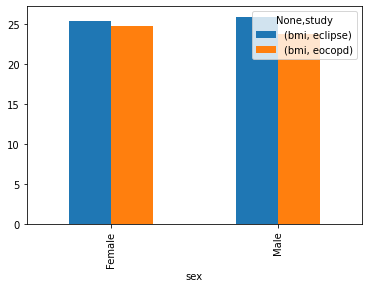

In [53]:
plotdf.plot(kind = 'bar')

-----

## Orthopnea variables across studies
<font color='darkgreen'>**Goal: Create harmonized variables for orthopnea and pneumonia which combine data from multiple studies, and compare participant distributions across these phenotypes**</font> 

In this example, we will be harmonizing variables related to `orthopnea`. Orthopnea is shortness of breath that occurs when individuals lie flat. Because of this, people with orthopnea have to sleep propped up in bed or sitting in a chair. You can read more about this condition [here](https://www.sleepfoundation.org/sleep-apnea/orthopnea).

Let's start by doing a search in PIC-SURE for concept paths containing `orthopnea`.

### Search and find orthopnea variables

In [54]:
orthopnea_dictionary = bdc.useDictionary().dictionary().find("orthopnea")
orthopnea_dataframe = orthopnea_dictionary.dataframe()
print(orthopnea_dataframe.shape)
orthopnea_dataframe[['columnmeta_name', 'columnmeta_description', 'values', 'columnmeta_study_id']].head()

(43, 31)


,columnmeta_name,columnmeta_description,values,columnmeta_study_id
0,ORTHOPNEAONSET,F136 Orthopnea at event onset,"[No / Not Recorded, Yes]",phs000200
1,SPEC_SYM,,"['KNOT R GRAIN', 'R GRAIN KNOT', 'STOMACH HURT...",phs002348
2,d_C_dyspnea_combo,Calculated variable combining admission signs ...,"[NO, YES]",phs002363
3,G3A163,DO YOU/HAVE YOU NEEDED TO SLEEP ON TWO OR MORE...,"[NO, YES]",phs000007
4,H106,DO YOU/HAVE YOU NEEDED TO SLEEP ON TWO OR MORE...,"[NO, YES]",phs000007


As shown in the resulting dataframe, orthopnea is often recorded as a something like `sleep on two or more pillows to help you breathe?`

Let's do a search for `pillows` in PIC-SURE to explore those concept paths.

In [55]:
pillows_dictionary = bdc.useDictionary().dictionary().find("pillows")
pillows_dataframe = pillows_dictionary.dataframe()
pillows_dataframe[['columnmeta_name', 'columnmeta_description', 'values', 'columnmeta_study_id']].head()

,columnmeta_name,columnmeta_description,values,columnmeta_study_id
0,HFpillows,Do you sleep on 2 or more pillows to improve y...,"[Don't know, No, Refused, Yes]",phs000286
1,MHXB47,47. E. Congestive heart failure. Have you had ...,"[Don't Know, No, Refused, Yes]",phs000286
2,NAME104,ACTIVITY NAME,"[AIR CONDITIONER, ANTIQUING, AQUA AEROBICS, AQ...",phs000287
3,G3A163,DO YOU/HAVE YOU NEEDED TO SLEEP ON TWO OR MORE...,"[NO, YES]",phs000007
4,H106,DO YOU/HAVE YOU NEEDED TO SLEEP ON TWO OR MORE...,"[NO, YES]",phs000007


As shown in the resulting dataframe, there are some concept paths related to orthopnea that were not captured by the previous `orthopnea` search, such as `Do you sleep on 2 or more pillows to improve your breathing?` from the Jackson Heart Study (JHS) Cohort (phs000286). In fact, the JHS dataset was not returned at all when we searched for `orthopnea`. 

This is problematic for researchers studying these types of variables, since the concept paths of interest may not always be captured by a single search term. To account for this, researchers must conduct exploratory searches to determine potential search terms.

Let's say we want to harmonize orthopnea variables from the following datasets: 
- FHS (phs000007)
- MESA (phs000209)
- WHI (phs000200)

We can first get all concept paths related to our terms of interest (`orthopnea` or `pillows`) and then filter to our studies of interest.

You can get the phs number associated with each study from the Data Access Dashboard.

In [56]:
# search pic-sure for 'orthopnea' and 'pillows'
harmonized_dictionary = bdc.useDictionary().dictionary().find("orthopnea|pillows")
harmonized_df = harmonized_dictionary.dataframe()

# filter to variables found in FHS, MESA, WHI
harmonized_df = harmonized_df[harmonized_df['studyId'].str.contains('phs000007|phs000209|phs000200')]
print(harmonized_df.shape)
harmonized_df[['columnmeta_name', 'columnmeta_description', 'values', 'columnmeta_study_id']]

(69, 31)


,columnmeta_name,columnmeta_description,values,columnmeta_study_id
0,G3A163,DO YOU/HAVE YOU NEEDED TO SLEEP ON TWO OR MORE...,"[NO, YES]",phs000007
1,H106,DO YOU/HAVE YOU NEEDED TO SLEEP ON TWO OR MORE...,"[NO, YES]",phs000007
2,g3a163,Do you/have you needed to sleep on two or more...,"[No, Yes]",phs000007
3,g3a163,Do you/have you needed to sleep on two or more...,"[No, Yes]",phs000007
4,h106,Medical History - Respiratory Symptoms - Part ...,"[No, Yes]",phs000007
...,...,...,...,...
88,H675,"WHEN YOU ARE NEAR ANIMALS, SUCH AS CATS, DOGS,...","[NO, YES]",phs000007
89,H678,"WHEN YOU ARE NEAR ANIMALS, SUCH AS CATS, DOGS,...","[NO, YES]",phs000007
90,H676,"WHEN YOU ARE NEAR ANIMALS, SUCH AS CATS, DOGS,...","[NO, YES]",phs000007
91,H679,"WHEN YOU ARE NEAR ANIMALS, SUCH AS CATS, DOGS,...","[NO, YES]",phs000007


After browsing the available variables, we decided to choose the following:

In [57]:
orthopnea_variables_of_interest = harmonized_df[harmonized_df['columnmeta_description'].isin(['Orthopnea', 
                                                                                   'F136 Orthopnea', 
                                                                                   'SLEEP ON 2+ PILLOWS TO HELP BREATHING'])]

# save variable paths for querying data
orthopnea_variable_paths_of_interest = orthopnea_variables_of_interest['columnmeta_HPDS_PATH'].tolist()

orthopnea_variables_of_interest[['columnmeta_name', 'columnmeta_description', 'values', 'columnmeta_study_id']]

,columnmeta_name,columnmeta_description,values,columnmeta_study_id
19,ORTHOPNEA,F136 Orthopnea,"[No/Not Recorded, Yes]",phs000200
68,slppllwf,SLEEP ON 2+ PILLOWS TO HELP BREATHING,"[DO NOT KNOW, NO, YES]",phs000209


### Search and find pneumonia variables

As part of our research, let's say we are interested in exploring the relationship between pneumonia and orthopnea. Let's save concept paths related to `pneumonia` as well. 

In [58]:
# search pic-sure for 'pneumonia'
harmonized_dictionary = bdc.useDictionary().dictionary().find("pneumonia")
harmonized_df = harmonized_dictionary.dataframe()

# filter to variables found in FHS, MESA, WHI
harmonized_df = harmonized_df[harmonized_df['columnmeta_study_id'].str.contains('phs000007|phs000209|phs000200')]
print(harmonized_df.shape)
harmonized_df[['columnmeta_name', 'columnmeta_description', 'values', 'columnmeta_study_id', 'varId']]

(70, 33)


,columnmeta_name,columnmeta_description,values,columnmeta_study_id,varId
8,PNEUMONIASHOT,Ever had a pneumonia shot,"[Don't know / Not sure, No, Yes]",phs000200,phv00283206
9,G3A547,HAVE YOU EVER HAD PNEUMONIA (INCLUDING BRONCHO...,"[NO, YES]",phs000007,phv00021300
10,g3a547,Have you ever had pneumonia (including broncho...,"[No, Yes]",phs000007,phv00274127
11,g3a547,Have you ever had pneumonia (including broncho...,"[No, Yes]",phs000007,phv00274618
17,h654,Respiratory Disease Questionnaire - Technician...,"[No, Yes]",phs000007,phv00251710
...,...,...,...,...,...
258,FA105,UNDER MEDICAL CARE BUT NOT HOSPITALIZED SINCE ...,"[NO (B WITH CODE X IN COL. 35 OR 0), YES]",phs000007,phv00001117
276,cpntite1,CHLAMYDIA PNEUMONIAE (IgG ANTIBODIES),"[1+, DEFINITE, BUT DIM FLUORESCENCE (POS), 2+,...",phs000209,phv00084983
277,cpn1c,"CHLAMYDIA PNEUMONIAE RESULTS AS POS, NEG & NSF","[NEG, NSF, POS, missing]",phs000209,phv00084982
279,c_pneu_iga,Chlamydia Pneumoniae IgA titre,"[1:128, 1:16, 1:32, 1:64, Greater than or equa...",phs000007,phv00163420


After browsing the available variables, we decided to choose the following:

In [59]:
pneumonia_variables_of_interest = harmonized_df[harmonized_df['varId'].isin(['phv00255144', 
                                                                             'phv00083774', 
                                                                             'phv00283208'])]

# save variable paths for querying data
pneumonia_variable_paths_of_interest = pneumonia_variables_of_interest['columnmeta_HPDS_PATH'].tolist()

pneumonia_variables_of_interest[['values', 'columnmeta_study_id', 'columnmeta_description', 'columnmeta_name', 'columnmeta_var_id']]

,values,columnmeta_study_id,columnmeta_description,columnmeta_name,columnmeta_var_id
96,"[Maybe, No, Yes]",phs000007,Clinical Diagnostic Impression - Pneumonia,fw285,phv00255144
173,"[NO, YES]",phs000209,PNEUMONIA,qpneuma4,phv00083774
210,"[Don't know / Not sure, No, Yes]",phs000200,Pneumonia diagnosed by a physician,PNEUMONIA,phv00283208


### Query PIC-SURE for selected variables

In [60]:
# Initialize a query
authPicSure = bdc.useAuthPicSure()
orthopnea_query = authPicSure.query()
orthopnea_query.anyof().add(orthopnea_variable_paths_of_interest + pneumonia_variable_paths_of_interest)
orthopnea_results = orthopnea_query.getResultsDataFrame(low_memory=False)
orthopnea_results.head()

,Patient ID,\_Parent Study Accession with Subject ID\,\_Topmed Study Accession with Subject ID\,\_consents\,\phs000007\pht005142\phv00255144\fw285\,\phs000200\pht006215\phv00283208\PNEUMONIA\,\phs000200\pht006223\phv00283555\ORTHOPNEA\,\phs000209\pht001114\phv00083774\qpneuma4\,\phs000209\pht001121\phv00087203\slppllwf\
0,54745,phs000007.v31_175,NaN,phs000007.c1,No,NaN,NaN,NaN,NaN
1,54873,phs000007.v31_374,NaN,phs000007.c1,Yes,NaN,NaN,NaN,NaN
2,54900,phs000007.v31_418,NaN,phs000007.c1,No,NaN,NaN,NaN,NaN
3,54910,phs000007.v31_434,NaN,phs000007.c1,No,NaN,NaN,NaN,NaN
4,54952,phs000007.v31_510,NaN,phs000007.c1,No,NaN,NaN,NaN,NaN


In [61]:
# rename columns
orthopnea_results.columns = ['patient_id', 'parent_accession', 'topmed_accession', 'consent', 
                             'fhs_pneumonia', 'fhs_orthopnea', 'whi_pneumonia', 
                             'whi_orthopnea', 'mesa_pneumonia', 'mesa_orthopnea']
orthopnea_results.head()

ValueError: Length mismatch: Expected axis has 9 elements, new values have 10 elements

### Clean and wrangle data

In [ ]:
# convert consent code to study name
orthopnea_results['study'] = np.where(orthopnea_results['consent'].str.contains('phs000007'), 'fhs', 
                                      np.where(orthopnea_results['consent'].str.contains('phs000209'), 'mesa', 'whi'))
orthopnea_results.head()

In [ ]:
# combine orthopnea variables
orthopnea_results['orthopnea'] = orthopnea_results['fhs_orthopnea'].fillna(orthopnea_results['whi_orthopnea'])
orthopnea_results['orthopnea'] = orthopnea_results['orthopnea'].fillna(orthopnea_results['mesa_orthopnea'])
orthopnea_results.head()



In [ ]:
# combine pneumonia variables
orthopnea_results['pneumonia'] = orthopnea_results['fhs_pneumonia'].fillna(orthopnea_results['whi_pneumonia'])
orthopnea_results['pneumonia'] = orthopnea_results['pneumonia'].fillna(orthopnea_results['mesa_pneumonia'])
orthopnea_results.head()

As you may have noticed, the orthopnea and pneumonia variables are encoded differently between these studies. 

This means that we see a range of vales that need to be harmonized (printed below)

We need to create a consistent encoding across these studies. 

In [ ]:
print(orthopnea_results.orthopnea.value_counts())
print('\n')
print(orthopnea_results.pneumonia.value_counts())

We create a consistent mapping:

In [ ]:
mapping_df = pd.DataFrame({'raw': np.unique(np.array(list(orthopnea_results['orthopnea']) + list(orthopnea_results['pneumonia']))),
                           'harmonized': ['Unknown', 'Unknown', 'Unknown', 'No', 'No', 'No', 'Yes', 'Yes', 'Unknown']})

value_mapping_dictionary = dict(zip(mapping_df.raw, mapping_df.harmonized))

mapping_df

And apply it to our hamonized orthopnea and pneumonia columns

In [ ]:
orthopnea_results.orthopnea = orthopnea_results.orthopnea.map(value_mapping_dictionary)
orthopnea_results.pneumonia = orthopnea_results.pneumonia.map(value_mapping_dictionary)

print(orthopnea_results.orthopnea.value_counts())
print('\n')
print(orthopnea_results.pneumonia.value_counts())

Now that the variables have been encoded in the same way, we can use this dataframe for analysis and visualizations. 

### Visualize

In [ ]:
final_df = orthopnea_results
final_df['orthopnea'] = final_df['orthopnea']. fillna('Unknown')
final_df['pneumonia'] = final_df['pneumonia']. fillna('Unknown')

In [ ]:
# Filters to apply to the final_df to create figures
pneu_yes = final_df['pneumonia'] == 'Yes'
pneu_no = final_df['pneumonia'] == 'No'
ortho_yes = final_df['orthopnea'] == 'Yes'
ortho_no = final_df['orthopnea'] == 'No'
fhs = final_df['study'] == 'fhs'
mesa = final_df['study'] == 'mesa'
whi = final_df['study'] == 'whi'

In [ ]:
# FHS figure
pneu_count =  final_df[pneu_yes & ortho_no & fhs].count()['patient_id']
ortho_count = final_df[pneu_no & ortho_yes & fhs].count()['patient_id']
both_count =  final_df[pneu_yes & ortho_yes & fhs].count()['patient_id']
venn2(subsets = (pneu_count, ortho_count, both_count), set_labels = ('Pneumonia', 'Orthopnea'))
plt.title("FHS Dataset")
plt.show()

# MESA figure
pneu_count =  final_df[pneu_yes & ortho_no & mesa].count()['patient_id']
ortho_count = final_df[pneu_no & ortho_yes & mesa].count()['patient_id']
both_count =  final_df[pneu_yes & ortho_yes & mesa].count()['patient_id']
venn2(subsets = (pneu_count, ortho_count, both_count), set_labels = ('Pneumonia', 'Orthopnea'))
plt.title("MESA Dataset")
plt.show()

# WHI figure
pneu_count =  final_df[pneu_yes & ortho_no & whi].count()['patient_id']
ortho_count = final_df[pneu_no & ortho_yes & whi].count()['patient_id']
both_count =  final_df[pneu_yes & ortho_yes & whi].count()['patient_id']
venn2(subsets = (pneu_count, ortho_count, both_count), set_labels = ('Pneumonia', 'Orthopnea'))
plt.title("WHI Dataset")
plt.show()

# Combined figure
pneu_count =  final_df[pneu_yes & ortho_no].count()['patient_id']
ortho_count = final_df[pneu_no & ortho_yes].count()['patient_id']
both_count =  final_df[pneu_yes & ortho_yes].count()['patient_id']
venn2(subsets = (pneu_count, ortho_count, both_count), set_labels = ('Pneumonia', 'Orthopnea'))
plt.title("Combined results across FHS, MESA, and WHI")
plt.show()